In [2]:
import shap
import pandas as pd
import seaborn as sns

### Data loading & basic inspection

In [3]:
df = pd.read_csv(('kc_house_data.csv'))
print("number of rows:", df.shape[0])
df.sample(3)

number of rows: 21613


,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
6118,5379804393,20150217T000000,325000.0,4,2.75,1960,8937,1.0,0,0,...,7,980,980,1954,0,98188,47.4510,-122.278,1480,10016
15866,2126049265,20141021T000000,495000.0,3,1.75,1770,10080,1.0,0,0,...,8,1770,0,1968,0,98125,47.7218,-122.306,1860,10456
5942,2024059127,20150109T000000,908950.0,4,2.75,3090,6200,2.0,0,0,...,9,3090,0,2014,0,98006,47.5538,-122.189,2890,10108


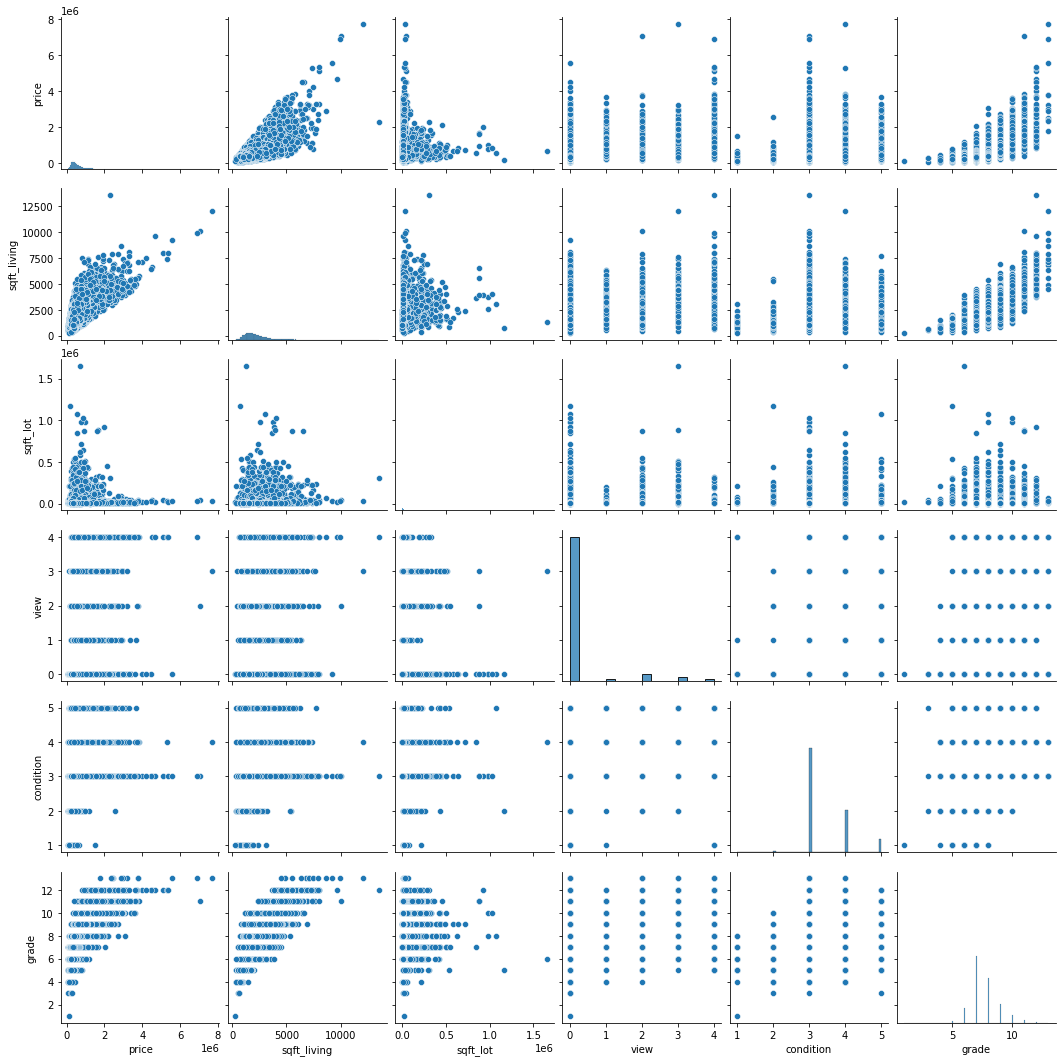

In [4]:
COLS = ["price", "sqft_living", "sqft_lot", "view", "condition", "grade"]
sns.pairplot(df[COLS])

### 1. For the selected data set, train at least one tree-based ensemble model (random forest, gbm, catboost or any other boosting)

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

X_COLS = ["sqft_living", "sqft_lot", "view", "condition", "grade"]

X, y = df[X_COLS], df["price"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=0)
rf = RandomForestRegressor(random_state=0, n_jobs=-1).fit(X_train, y_train)

### 2. for some selected observations (two or three) from this dataset, calculate predictions for model (1)

In [32]:
SAMPLE_SIZE = 2
SEED = 1

X_test_sample = X_test.sample(SAMPLE_SIZE, random_state=SEED)
test_sample = X_test_sample.copy()
test_sample['predicted_price'] = rf.predict(test_sample)
test_sample

,sqft_living,sqft_lot,view,condition,grade,predicted_price
19442,1770,6000,0,5,7,546679.72
2179,2690,8890,4,4,10,1307220.00


### 3. For observations selected in (2), calculate the decomposition of model prediction using SHAP, Break Down or both (packages for R: DALEX, iml, packages for python: shap, dalex).

In [33]:
shap.initjs()

In [63]:
EXPLAINER_SAMPLE_SIZE = 100

explainer_X_test = X_test.sample(EXPLAINER_SAMPLE_SIZE)
explainer = shap.Explainer(rf, explainer_X_test)
shap_values = explainer(X_test_sample)

### 4. find two observations in the data set, such that they have different most important variables (e.g. age and gender are the most important for observation A, but race and class for observation B)

Observation #1: Most important feature was the `condition`. Its shap value is equal to ~108k $ 

In [64]:
shap_values[0]

.values =
array([-37318.60249634,  46242.45482994, -24358.98545753, 108130.64071136,
       -91237.93487167])

.base_values =
545222.1408166667

.data =
array([1770, 6000,    0,    5,    7])

In [65]:
shap.plots.force(shap_values[0])

Observation #2: Most important feature was the `view`. Its shap value is equal to ~403.5k $

In [66]:
shap_values[1]

.values =
array([140970.61157036, -32242.17717194, 403494.26264946,  -2640.95601067,
       252416.1472493 ])

.base_values =
545222.1408166667

.data =
array([2690, 8890,    4,    4,   10])

In [67]:
shap.plots.force(shap_values[1])

### 5. (if possible) select one variable and find two observations in the data set such that for one observation this variable has a positive effect and for the other a negative effect

This is what happened for variable `view` and the two observations above. For the 1st observation view=0 had a large negative effect (the least attractive view), but for the 2nd observation view=4 (best) had a large positive effect.

### 6. train a second model (of any class, neural nets, linear, other boosting) and find an observation for which BD/shap attributions are different between the models

In [68]:
from sklearn.linear_model import LinearRegression

lin = LinearRegression()
lin.fit(X_train, y_train)
explainer_lin = shap.Explainer(lin, explainer_X_test)
shap_values_lin = explainer_lin(X_test_sample)

In [69]:
shap.plots.force(shap_values_lin[0])

### 7. Comment on the results for points (4), (5) and (6)

4.
Observation 1 and 2 were widely different, which was clearly reflected in obtained price predictions. The first house was much smaller and without attractive view. House #2 was large, has a great view and was built very well; great view had a great impact on the predicted price. On the other hand house 1 was in a good condition, which made it an important factor for its price.

5.
Since these observations had `view` values from opposite sides, naturally they had a widely different impact on the price.

6.
Surprisingly, for the linear model `sqft_lot` (unlike for the random forest) had almost no effect on the price. The attribution for the remaining features was fairly similar. This resulted in the predicted price being lower for Linear model. It might be due to limitations of the linear model, not handling well interactions between features and (unsurprisingly) non-linearities.